# Global Dataset Overview

This notebook provides a comprehensive overview of the OpenPowerlifting dataset including counts, distributions, missing data analysis, and comparison of existing scoring systems.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from utils import categorize_ipf_weightclass, map_division_to_age_group, calculate_retirement_status, create_quality_filter, categorize_lifters, categorize_federation_testing_status

# Load the processed dataset
df = pd.read_parquet("../data/processed/full_dataset.parquet")
print(f"Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")


Dataset loaded: 3,449,582 rows, 73 columns


## 0. Data Cleaning and Preparation


In [2]:
# Convert Lbs to Kg and fill missing Kg values
# Conversion factor: 1 lb = 0.453592 kg
LBS_TO_KG = 0.453592

# Find all Lbs columns and their corresponding Kg columns
lbs_cols = [col for col in df.columns if col.endswith('Lbs') or 'Lbs' in col]
print(f"Found {len(lbs_cols)} Lbs columns to convert...")

for lbs_col in lbs_cols:
    # Find corresponding Kg column (e.g., TotalLbs -> TotalKg)
    kg_col = lbs_col.replace('Lbs', 'Kg')
    
    if kg_col in df.columns:
        # Convert Lbs to Kg where Kg is missing
        # Only convert where Lbs exists and Kg is missing
        mask = df[lbs_col].notna() & df[kg_col].isna()
        if mask.sum() > 0:
            df.loc[mask, kg_col] = df.loc[mask, lbs_col] * LBS_TO_KG
            print(f"  Converted {mask.sum():,} values from {lbs_col} to {kg_col}")
    else:
        # If no Kg column exists, create one from Lbs
        if df[lbs_col].notna().sum() > 0:
            df[kg_col] = df[lbs_col] * LBS_TO_KG
            print(f"  Created {kg_col} from {lbs_col} ({df[lbs_col].notna().sum():,} values)")

# Now remove Lbs columns after conversion
print(f"\nRemoving {len(lbs_cols)} Lbs columns (converted to Kg)...")
df = df.drop(columns=lbs_cols)
print(f"After removing Lbs columns: {len(df.columns)} columns")

# Add Age Group categorization from Division (needed for FailedMeet logic)
# This must be done BEFORE FailedMeet flagging
if 'Division' in df.columns:
    print("\nAdding Age Group categorization from Division (for FailedMeet logic)...")
    df['AgeGroup'] = df['Division'].apply(map_division_to_age_group)
    print("✓ Age Group categorization complete")
else:
    print("⚠ Warning: Cannot add Age Group - missing Division column")
    df['AgeGroup'] = None

# Flag failed meets based on multiple criteria:
# 1. TotalKg is missing/empty
# 2. TotalKg < 150kg AND AgeGroup is NOT 'Youth' (Youth can have legitimately low totals)
if 'TotalKg' in df.columns:
    df['FailedMeet'] = (
        df['TotalKg'].isna() |  # Missing total
        (
            (df['TotalKg'] < 150) &  # Low total
            (df['TotalKg'].notna()) &  # But total exists
            (df['AgeGroup'] != 'Youth')  # And not a Youth lifter
        )
    )
    failed_count = df['FailedMeet'].sum()
    print(f"\nFlagged {failed_count:,} failed meets")
    print(f"  This represents {failed_count/len(df)*100:.2f}% of all entries")
    print(f"  Criteria: Missing TotalKg OR (TotalKg < 150kg AND AgeGroup != 'Youth')")

# Ensure Sex column exists and filter to M/F only for gender analysis
if 'Sex' in df.columns:
    print(f"\nSex distribution:")
    print(df['Sex'].value_counts())
    # Create analysis dataframe (can include all, but we'll separate by M/F in analysis)
    df_analysis = df.copy()
else:
    print("⚠ Warning: Sex column not found")
    df_analysis = df.copy()

# Add IPF Weight Class categorization
if 'BodyweightKg' in df_analysis.columns and 'Sex' in df_analysis.columns:
    print("\nAdding IPF Weight Class categorization...")
    df_analysis['IPF_WeightClass'] = df_analysis.apply(
        lambda row: categorize_ipf_weightclass(row['BodyweightKg'], row['Sex']), 
        axis=1
    )
    
    # Show distribution of IPF weight classes
    print("\nIPF Weight Class distribution:")
    ipf_counts = df_analysis['IPF_WeightClass'].value_counts().sort_index()
    print(ipf_counts)
    
    # Show by gender
    print("\nIPF Weight Class by Gender:")
    if 'Sex' in df_analysis.columns:
        ipf_gender = pd.crosstab(df_analysis['Sex'], df_analysis['IPF_WeightClass'], margins=True)
        print(ipf_gender)
else:
    print("⚠ Warning: Cannot add IPF Weight Class - missing BodyweightKg or Sex column")
    df_analysis['IPF_WeightClass'] = None

# Age Group already calculated earlier (for FailedMeet logic)
# Just show the distribution
if 'AgeGroup' in df_analysis.columns:
    print("\nAge Group distribution (from Division - 100% coverage):")
    age_group_counts = df_analysis['AgeGroup'].value_counts()
    print(age_group_counts)
    
    # Show by gender
    if 'Sex' in df_analysis.columns:
        print("\nAge Group by Gender:")
        age_by_sex = pd.crosstab(df_analysis['Sex'], df_analysis['AgeGroup'], margins=True)
        print(age_by_sex)
    
    print("\n✓ Age Group categorization complete (using Division - 100% coverage)")
else:
    print("⚠ Warning: Age Group not found - should have been calculated earlier")
    if 'Division' in df_analysis.columns:
        df_analysis['AgeGroup'] = df_analysis['Division'].apply(map_division_to_age_group)
        print("  Calculated AgeGroup from Division as fallback")
    else:
        df_analysis['AgeGroup'] = None

# Calculate retirement status
print("\n" + "="*80)
print("CALCULATING RETIREMENT STATUS")
print("="*80)
df_analysis = calculate_retirement_status(df_analysis)
retired_count = df_analysis['Retired'].sum()
print(f"Flagged {retired_count:,} entries from retired lifters (4+ years since last meet)")
print(f"  This represents {retired_count/len(df_analysis)*100:.2f}% of all entries")

# Create quality filter (excludes outliers and invalid data)
print("\n" + "="*80)
print("CREATING QUALITY FILTER")
print("="*80)
quality_mask = create_quality_filter(df_analysis)
filtered_out = (~quality_mask).sum()
print(f"Quality filter will exclude {filtered_out:,} entries ({filtered_out/len(df_analysis)*100:.2f}%)")
print(f"  Remaining entries for analysis: {quality_mask.sum():,} ({quality_mask.sum()/len(df_analysis)*100:.2f}%)")

# Create clean dataset (filtered)
df_clean = df_analysis[quality_mask].copy()
print(f"\n✓ Using filtered dataset with {len(df_clean):,} entries")

# Categorize lifters (New/Intermediate/Advanced)
print("\n" + "="*80)
print("CATEGORIZING LIFTERS")
print("="*80)
df_clean = categorize_lifters(df_clean)
print("✓ Lifters categorized into New, Intermediate, and Advanced")

# Categorize federation testing status (Drug Tested vs Untested)
print("\n" + "="*80)
print("CATEGORIZING FEDERATION TESTING STATUS")
print("="*80)
df_clean = categorize_federation_testing_status(df_clean)
df_analysis = categorize_federation_testing_status(df_analysis)
testing_status_counts = df_clean['FederationTestingStatus'].value_counts()
print("Federation Testing Status distribution:")
print(testing_status_counts)
print(f"✓ Federation testing status categorized")

print(f"\n✓ Data cleaning complete")
print(f"Final dataset: {len(df_analysis):,} rows, {len(df_analysis.columns)} columns")
print(f"Clean dataset (filtered): {len(df_clean):,} rows")


Found 18 Lbs columns to convert...
  Converted 14,797 values from BodyweightLbs to BodyweightKg
  Converted 8,421 values from Deadlift1Lbs to Deadlift1Kg
  Converted 8,113 values from Deadlift2Lbs to Deadlift2Kg
  Converted 7,365 values from Deadlift3Lbs to Deadlift3Kg
  Converted 543 values from Deadlift4Lbs to Deadlift4Kg
  Converted 12,661 values from Best3DeadliftLbs to Best3DeadliftKg
  Converted 15,828 values from TotalLbs to TotalKg
  Converted 5,692 values from Squat1Lbs to Squat1Kg
  Converted 5,620 values from Squat2Lbs to Squat2Kg
  Converted 5,423 values from Squat3Lbs to Squat3Kg
  Converted 8,852 values from Best3SquatLbs to Best3SquatKg
  Converted 8,996 values from Bench1Lbs to Bench1Kg
  Converted 8,579 values from Bench2Lbs to Bench2Kg
  Converted 7,780 values from Bench3Lbs to Bench3Kg
  Converted 13,677 values from Best3BenchLbs to Best3BenchKg
  Converted 396 values from Bench4Lbs to Bench4Kg
  Converted 52 values from Squat4Lbs to Squat4Kg

Removing 18 Lbs columns

## 1. Basic Counts


In [3]:
# Count unique lifters, meets, federations
unique_lifters = df['Name'].nunique() if 'Name' in df.columns else 0
unique_meets = df['MeetPath'].nunique() if 'MeetPath' in df.columns else 0
unique_federations = df['Federation'].nunique() if 'Federation' in df.columns else 0

print("=== Dataset Overview ===")
print(f"Total entries: {len(df):,}")
print(f"Unique lifters: {unique_lifters:,}")
print(f"Unique meets: {unique_meets:,}")
print(f"Unique federations: {unique_federations:,}")
print(f"Date range: {df['MeetDate'].min()} to {df['MeetDate'].max()}")


=== Dataset Overview ===
Total entries: 3,449,582
Unique lifters: 851,861
Unique meets: 53,985
Unique federations: 425
Date range: 1964-09-05 00:00:00 to 2025-12-27 00:00:00


## 2. Distribution Analysis

### 2.0. Overall Distribution Statistics (Gender × Weight Class × Age Group)


In [4]:
# Key distributions - SEPARATED BY GENDER, IPF WEIGHT CLASS, AGE GROUP, AND FEDERATION TESTING STATUS
# Overall distributions are removed as they skew data - all analysis must be gender × weight class × age group × testing status separated

key_cols = ['TotalKg', 'BodyweightKg', 'Wilks', 'Dots', 'Goodlift']

print("=== Distribution Statistics by Gender, IPF Weight Class, Age Group, and Federation Testing Status ===")
print("Note: Overall distributions removed - all analysis is separated by (Gender × Weight Class × Age Group × Testing Status)")
print("      to prevent data skewing from combining different weight classes, age groups, and testing statuses.\n")
print("      Distributions are split into: Drug Tested Federations vs Untested Federations\n")

# Check if we have the required columns
if 'IPF_WeightClass' not in df_analysis.columns or 'Sex' not in df_analysis.columns or 'AgeGroup' not in df_analysis.columns or 'FederationTestingStatus' not in df_analysis.columns:
    print("⚠ Warning: IPF_WeightClass, Sex, or AgeGroup column missing. Cannot perform separated analysis.")
    print("   Falling back to overall statistics...")
    for col in key_cols:
        if col in df.columns:
            print(f"\n{col} (Overall - NOT RECOMMENDED):")
            print(df[col].describe())
            print(f"  Missing: {df[col].isna().sum():,} ({df[col].isna().sum()/len(df)*100:.1f}%)")
else:
    # Filter to entries with IPF weight class, gender, age group, and testing status
    valid_df = df_analysis[
        (df_analysis['IPF_WeightClass'].notna()) & 
        (df_analysis['Sex'].isin(['M', 'F'])) &
        (df_analysis['AgeGroup'].notna()) &
        (df_analysis['FederationTestingStatus'].isin(['Drug Tested', 'Untested']))
    ].copy()
    
    print(f"Entries with valid IPF Weight Class, Gender, Age Group, and Testing Status: {len(valid_df):,} ({len(valid_df)/len(df_analysis)*100:.1f}%)\n")
    
    # Show split by testing status
    testing_split = valid_df['FederationTestingStatus'].value_counts()
    print("Entries by Federation Testing Status:")
    for status, count in testing_split.items():
        print(f"  {status}: {count:,} ({count/len(valid_df)*100:.1f}%)")
    print()
    
    # Get all unique (Gender × Weight Class × Age Group × Testing Status) combinations
    gender_wc_age_test_combos = valid_df.groupby(['Sex', 'IPF_WeightClass', 'AgeGroup', 'FederationTestingStatus'], observed=True).size().reset_index(name='count')
    gender_wc_age_test_combos = gender_wc_age_test_combos.sort_values(['Sex', 'IPF_WeightClass', 'AgeGroup', 'FederationTestingStatus'])
    
    print(f"Total (Gender × Weight Class × Age Group × Testing Status) combinations: {len(gender_wc_age_test_combos)}")
    print("\nTop 20 combinations with sufficient data (>100 entries):")
    sufficient = gender_wc_age_test_combos[gender_wc_age_test_combos['count'] >= 100].head(20)
    print(sufficient.to_string(index=False))
    
    # For each key column, show summary by (Gender × Weight Class × Age Group × Testing Status)
    print("\n" + "="*80)
    print("DETAILED STATISTICS BY GENDER, WEIGHT CLASS, AGE GROUP, AND TESTING STATUS")
    print("="*80)
    print("Note: Statistics are shown separately for Drug Tested and Untested federations")
    print("="*80)
    
    # Standard age group order
    age_group_order = ['Youth', 'Teen', 'Sub-Junior', 'Junior', 'Open', 'Masters I', 'Masters II', 'Masters III', 'Masters IV']
    
    for col in key_cols:
        if col in valid_df.columns:
            print(f"\n{'='*80}")
            print(f"{col.upper()} - Statistics by (Gender × IPF Weight Class × Age Group × Testing Status)")
            print(f"{'='*80}")
            
            # Group by Sex, IPF_WeightClass, AgeGroup, and FederationTestingStatus
            stats = valid_df.groupby(['Sex', 'IPF_WeightClass', 'AgeGroup', 'FederationTestingStatus'], observed=True)[col].agg([
                'count', 'mean', 'median', 'std', 'min', 'max'
            ]).round(1)
            
            # Filter to groups with at least 10 entries for meaningful statistics
            counts = valid_df.groupby(['Sex', 'IPF_WeightClass', 'AgeGroup', 'FederationTestingStatus'], observed=True)[col].count()
            valid_groups = counts[counts >= 10].index
            
            if len(valid_groups) > 0:
                stats_filtered = stats.loc[valid_groups]
                
                # Show statistics organized by Gender and Weight Class, then Age Group
                men_classes = ['59kg', '66kg', '74kg', '83kg', '93kg', '105kg', '120kg', '120+kg']
                women_classes = ['47kg', '52kg', '57kg', '63kg', '69kg', '76kg', '84kg', '84+kg']
                
                # Show statistics split by Testing Status (Drug Tested vs Untested)
                for testing_status in ['Drug Tested', 'Untested']:
                    print(f"\n{'='*80}")
                    print(f"{testing_status.upper()} FEDERATIONS")
                    print(f"{'='*80}")
                    
                    for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
                        print(f"\n{label}:")
                        print("-" * 80)
                        
                        for wc in classes:
                            # Get stats for this weight class, gender, and testing status
                            try:
                                wc_stats = stats_filtered.xs((sex, wc, testing_status), level=['Sex', 'IPF_WeightClass', 'FederationTestingStatus'])
                                
                                if len(wc_stats) > 0:
                                    # Reorder by age group order
                                    available_ages = [ag for ag in age_group_order if ag in wc_stats.index]
                                    wc_stats = wc_stats.reindex(available_ages)
                                    
                                    print(f"\n  {label} - {wc}:")
                                    print(f"  {'Age Group':<15} {'Count':<8} {'Mean':<10} {'Median':<10} {'Std':<10} {'Min':<10} {'Max':<10}")
                                    print(f"  {'-'*15} {'-'*8} {'-'*10} {'-'*10} {'-'*10} {'-'*10} {'-'*10}")
                                    for ag, row in wc_stats.iterrows():
                                        print(f"  {str(ag):<15} {int(row['count']):<8} {row['mean']:<10.1f} {row['median']:<10.1f} {row['std']:<10.1f} {row['min']:<10.1f} {row['max']:<10.1f}")
                            except (KeyError, IndexError):
                                # No data for this weight class/gender/testing status combination
                                pass
                
                # Show missing data by group
                missing_by_group = valid_df.groupby(['Sex', 'IPF_WeightClass', 'AgeGroup', 'FederationTestingStatus'], observed=True)[col].apply(
                    lambda x: x.isna().sum()
                )
                missing_by_group = missing_by_group[missing_by_group > 0]
                if len(missing_by_group) > 0:
                    print(f"\nMissing data by group (showing top 20):")
                    print(missing_by_group.head(20).to_string())
            else:
                print(f"⚠ No groups with sufficient data (≥10 entries) for {col}")


=== Distribution Statistics by Gender, IPF Weight Class, Age Group, and Federation Testing Status ===
Note: Overall distributions removed - all analysis is separated by (Gender × Weight Class × Age Group × Testing Status)
      to prevent data skewing from combining different weight classes, age groups, and testing statuses.

      Distributions are split into: Drug Tested Federations vs Untested Federations

Entries with valid IPF Weight Class, Gender, Age Group, and Testing Status: 3,274,377 (94.9%)

Entries by Federation Testing Status:
  Untested: 2,449,082 (74.8%)
  Drug Tested: 825,295 (25.2%)

Total (Gender × Weight Class × Age Group × Testing Status) combinations: 224

Top 20 combinations with sufficient data (>100 entries):
Sex IPF_WeightClass    AgeGroup FederationTestingStatus  count
  F            47kg      Junior             Drug Tested   2285
  F            47kg      Junior                Untested  10078
  F            47kg   Masters I                Untested   2807
  F  

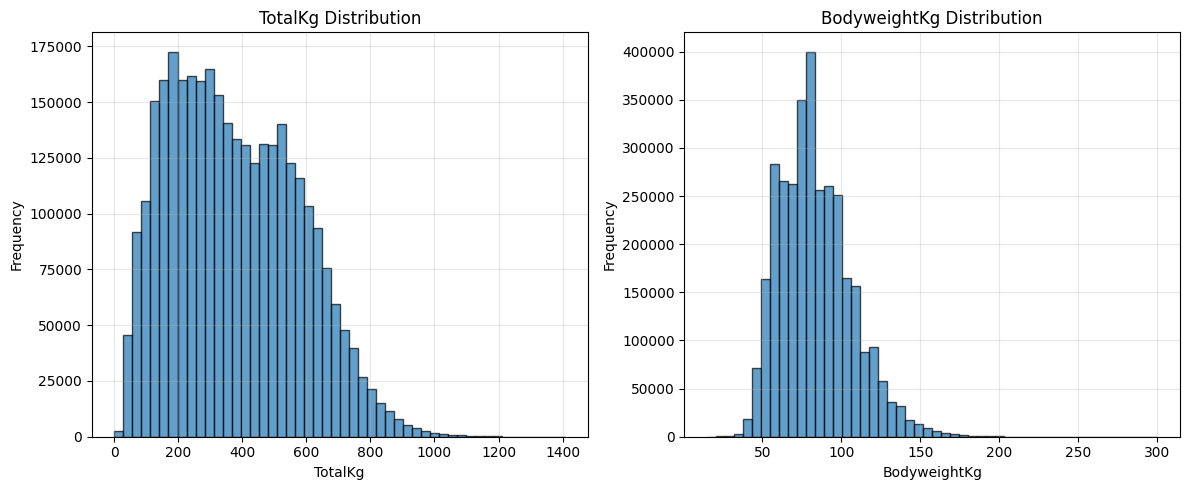

✓ Displayed 2 distribution plots


In [5]:
# Visualize distributions
# Filter to only available columns
available_cols = [col for col in key_cols if col in df.columns]

if len(available_cols) > 0:
    # Calculate grid size
    n_cols = min(3, len(available_cols))
    n_rows = (len(available_cols) + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    
    # Handle single subplot case
    if len(available_cols) == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, col in enumerate(available_cols):
        ax = axes[idx]
        data = df[col].dropna()
        if len(data) > 0:
            ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
            ax.set_title(f'{col} Distribution')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
            ax.grid(True, alpha=0.3)
        else:
            ax.text(0.5, 0.5, f'No data for {col}', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{col} Distribution (No Data)')
    
    # Hide unused subplots
    for idx in range(len(available_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('../data/processed/distributions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Displayed {len(available_cols)} distribution plots")
else:
    print("⚠ No columns available for visualization")


### 2.1. Bodyweight Distribution within IPF Weight Classes


=== Bodyweight Distribution within IPF Weight Classes (Gender-Separated) ===
Valid entries: 3,274,377

Bodyweight Statistics within each IPF Weight Class:

MALE:
--------------------------------------------------------------------------------
Weight Class    Count      Mean BW      Median BW    Std          Min        Max       
--------------------------------------------------------------------------------
59kg            291480     58.7         59.2         6.1          16.0       66.0      
66kg            288926     70.7         71.7         2.7          66.0       74.0      
74kg            434739     79.3         80.4         2.8          74.0       83.0      
83kg            413465     88.7         89.0         2.5          83.0       93.0      
93kg            386445     99.1         98.9         3.2          93.0       105.0     
105kg           288066     111.4        109.9        4.5          105.0      120.0     
120+kg          213030     134.4        130.3        14.2   

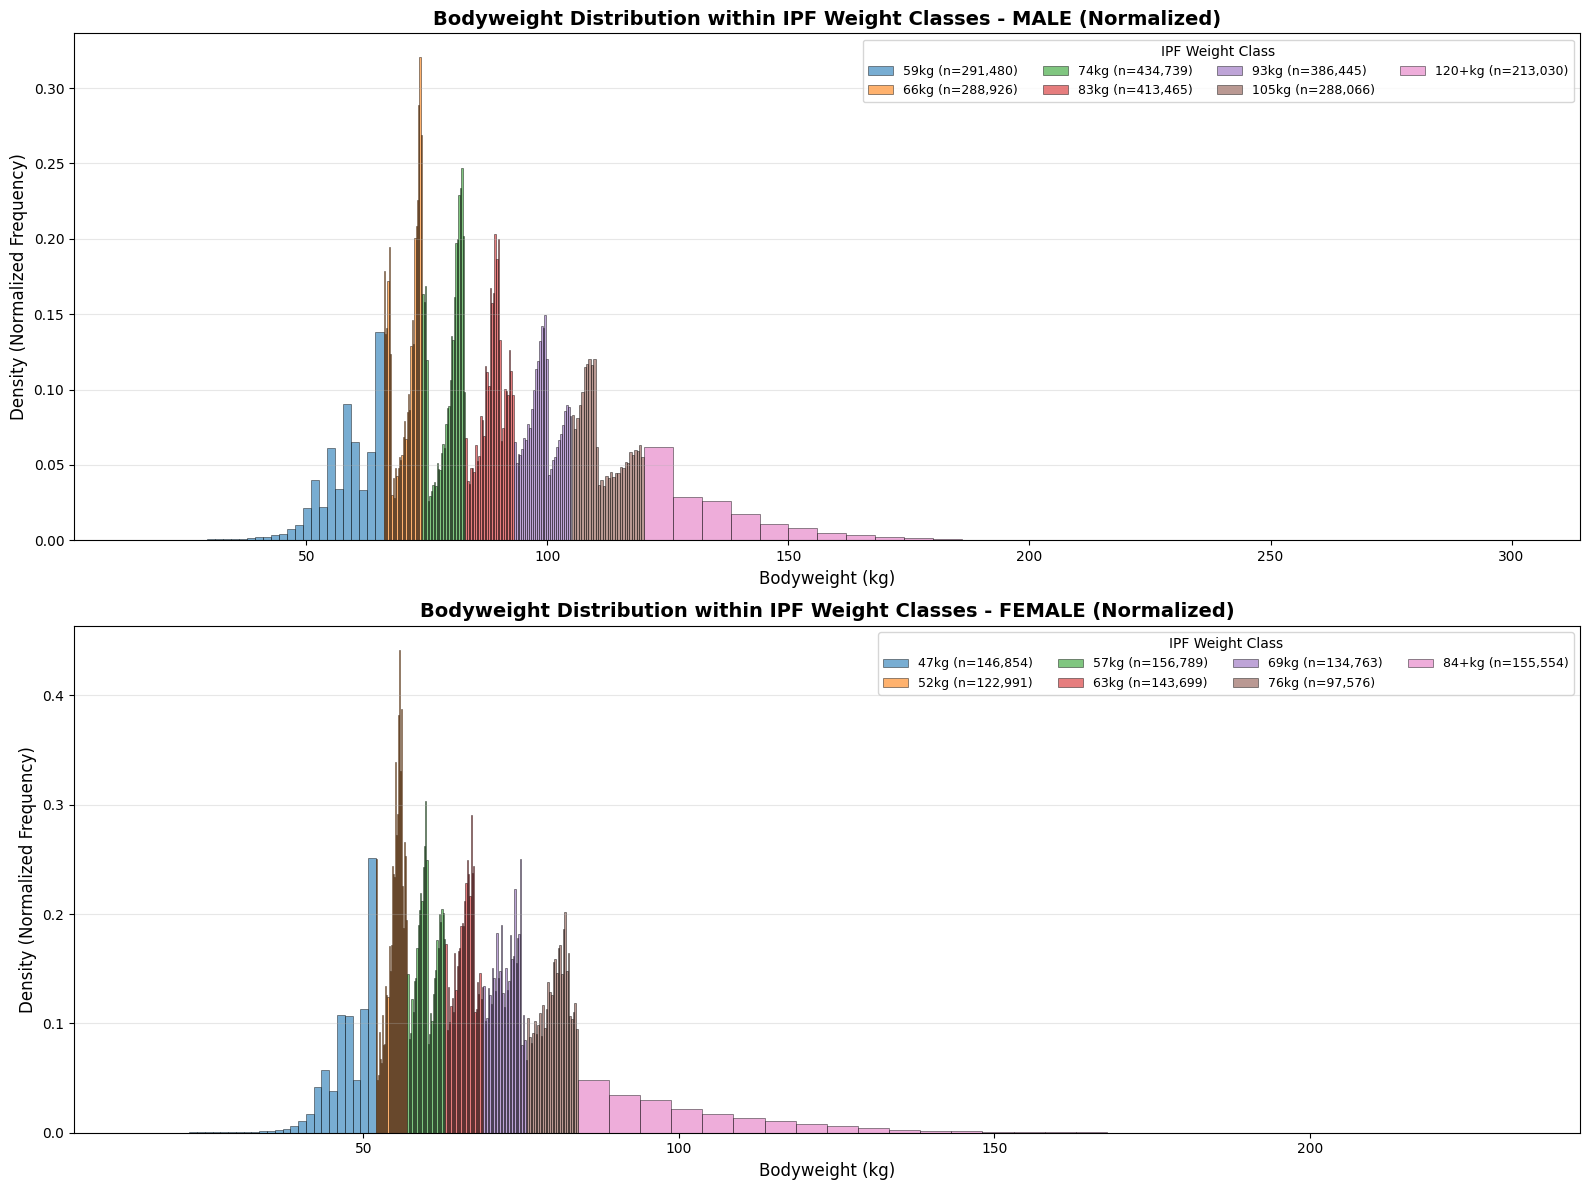

✓ Visualizations saved


In [6]:
# Bodyweight distribution within each IPF weight class - SEPARATED BY GENDER
# Shows how actual bodyweights are distributed within each IPF weight class category

if 'BodyweightKg' in df_analysis.columns and 'IPF_WeightClass' in df_analysis.columns and 'Sex' in df_analysis.columns:
    # Filter to entries with bodyweight, IPF weight class, and gender
    valid_df = df_analysis[
        (df_analysis['BodyweightKg'].notna()) & 
        (df_analysis['IPF_WeightClass'].notna()) &
        (df_analysis['Sex'].isin(['M', 'F']))
    ].copy()
    
    if len(valid_df) > 0:
        print("=== Bodyweight Distribution within IPF Weight Classes (Gender-Separated) ===")
        print(f"Valid entries: {len(valid_df):,}\n")
        
        # Get IPF weight classes in order
        men_classes = ['59kg', '66kg', '74kg', '83kg', '93kg', '105kg', '120kg', '120+kg']
        women_classes = ['47kg', '52kg', '57kg', '63kg', '69kg', '76kg', '84kg', '84+kg']
        
        # Statistics by (Gender × IPF Weight Class)
        print("Bodyweight Statistics within each IPF Weight Class:")
        print("="*80)
        
        for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
            print(f"\n{label}:")
            print("-" * 80)
            print(f"{'Weight Class':<15} {'Count':<10} {'Mean BW':<12} {'Median BW':<12} {'Std':<12} {'Min':<10} {'Max':<10}")
            print("-" * 80)
            
            for wc in classes:
                group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                
                if len(group_df) >= 10:
                    stats = group_df['BodyweightKg'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(1)
                    print(f"{wc:<15} {int(stats['count']):<10} {stats['mean']:<12.1f} {stats['median']:<12.1f} "
                          f"{stats['std']:<12.1f} {stats['min']:<10.1f} {stats['max']:<10.1f}")
        
        # Visualizations - histograms of bodyweight within each IPF weight class
        # Use density=True to normalize frequencies so distributions are comparable
        print("\n\nGenerating visualizations...")
        
        fig, axes = plt.subplots(2, 1, figsize=(16, 12))
        
        for idx, (sex, classes, label) in enumerate([('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]):
            ax = axes[idx]
            
            for wc in classes:
                group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                
                if len(group_df) >= 50:  # Only plot groups with sufficient data
                    data = group_df['BodyweightKg'].dropna()
                    if len(data) > 0:
                        # Use density=True to normalize - this makes distributions comparable
                        # regardless of the number of entries in each weight class
                        ax.hist(data, bins=30, alpha=0.6, density=True,
                               label=f'{wc} (n={len(data):,})', edgecolor='black', linewidth=0.5)
            
            ax.set_title(f'Bodyweight Distribution within IPF Weight Classes - {label} (Normalized)', 
                        fontsize=14, fontweight='bold')
            ax.set_xlabel('Bodyweight (kg)', fontsize=12)
            ax.set_ylabel('Density (Normalized Frequency)', fontsize=12)
            ax.legend(title='IPF Weight Class', ncol=4, fontsize=9)
            ax.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.savefig('../data/processed/bodyweight_within_ipf_weightclass.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✓ Visualizations saved")
    else:
        print("⚠ No valid entries with BodyweightKg, IPF_WeightClass, and Gender")
else:
    print("⚠ Missing required columns (BodyweightKg, IPF_WeightClass, or Sex) for analysis")


### 2.2. Federation Testing Status Analysis


=== Federation Testing Status Analysis ===

Overall Distribution by Testing Status:
  Untested: 1,062,860 entries (76.9%)
  Drug Tested: 319,172 entries (23.1%)

Number of Federations by Testing Status:
  Untested: 343 federations
  Drug Tested: 67 federations

TOP FEDERATIONS BY ENTRY COUNT (Split by Testing Status)

DRUG TESTED FEDERATIONS (Top 15 by entry count):
--------------------------------------------------------------------------------
Federation                     Entries         % of {status}  
--------------------------------------------------------------------------------
uspa                           126,174         39.5           %
apf                            20,309          6.4            %
rps                            19,122          6.0            %
wrpf-usa                       14,983          4.7            %
amp                            14,851          4.7            %
bpu                            10,634          3.3            %
wrpf                  

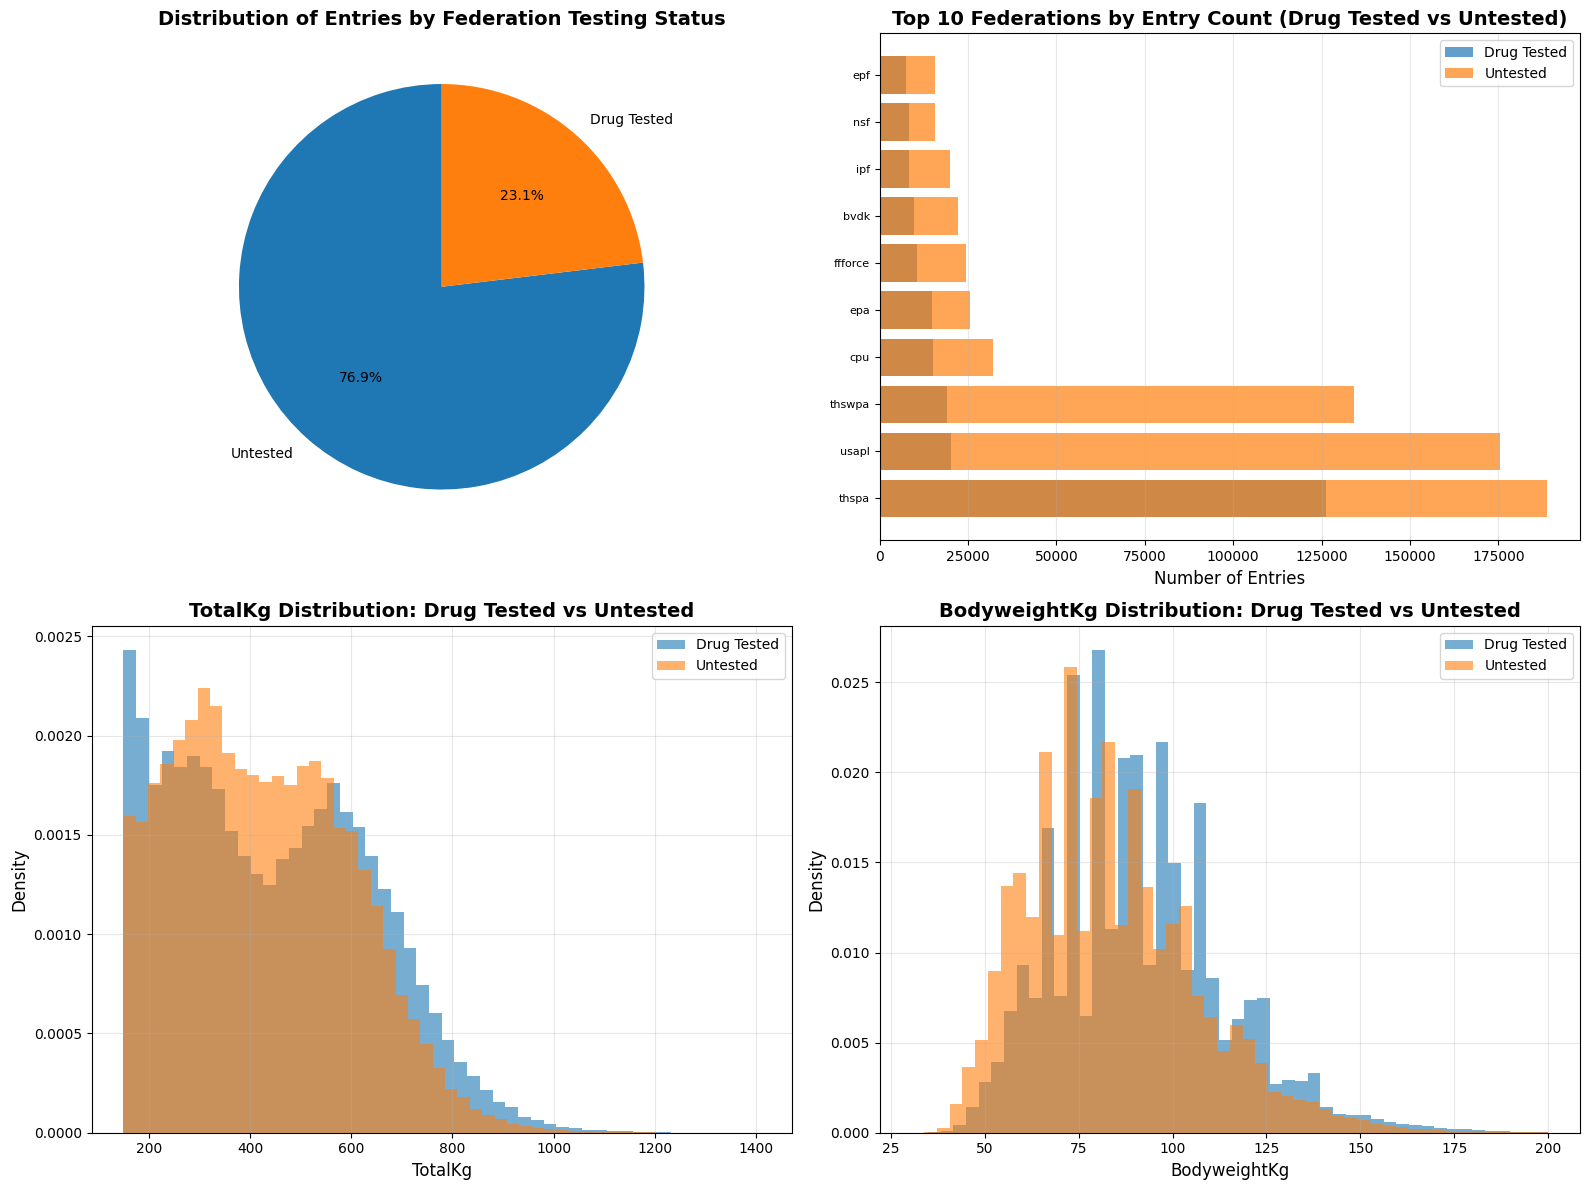

✓ Visualizations saved


In [7]:
# Federation Testing Status Analysis
# Shows distribution of drug tested vs untested federations and their characteristics

if 'FederationTestingStatus' in df_clean.columns and 'Federation' in df_clean.columns:
    print("=== Federation Testing Status Analysis ===")
    print()
    
    # Overall distribution
    testing_dist = df_clean['FederationTestingStatus'].value_counts()
    print("Overall Distribution by Testing Status:")
    for status, count in testing_dist.items():
        print(f"  {status}: {count:,} entries ({count/len(df_clean)*100:.1f}%)")
    print()
    
    # Federations by testing status
    fed_by_status = df_clean.groupby('Federation')['FederationTestingStatus'].first().value_counts()
    print("Number of Federations by Testing Status:")
    for status, count in fed_by_status.items():
        print(f"  {status}: {count} federations")
    print()
    
    # Top federations by entry count, split by testing status
    print("="*80)
    print("TOP FEDERATIONS BY ENTRY COUNT (Split by Testing Status)")
    print("="*80)
    
    for status in ['Drug Tested', 'Untested']:
        status_df = df_clean[df_clean['FederationTestingStatus'] == status]
        if len(status_df) > 0:
            fed_counts = status_df['Federation'].value_counts().head(15)
            print(f"\n{status.upper()} FEDERATIONS (Top 15 by entry count):")
            print("-" * 80)
            print(f"{'Federation':<30} {'Entries':<15} {'% of {status}':<15}")
            print("-" * 80)
            for fed, count in fed_counts.items():
                pct = count / len(status_df) * 100
                print(f"{fed:<30} {count:<15,} {pct:<15.1f}%")
    
    # Comparative statistics: Drug Tested vs Untested
    print("\n" + "="*80)
    print("COMPARATIVE STATISTICS: DRUG TESTED vs UNTESTED FEDERATIONS")
    print("="*80)
    
    comparison_cols = ['TotalKg', 'BodyweightKg']
    for col in comparison_cols:
        if col in df_clean.columns:
            print(f"\n{col.upper()}:")
            print("-" * 80)
            stats_comparison = df_clean.groupby('FederationTestingStatus')[col].agg([
                'count', 'mean', 'median', 'std', 'min', 'max'
            ]).round(1)
            print(stats_comparison.to_string())
    
    # Visualizations
    print("\n\nGenerating visualizations...")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Distribution pie chart
    ax1 = axes[0, 0]
    testing_dist.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=90)
    ax1.set_title('Distribution of Entries by Federation Testing Status', fontsize=14, fontweight='bold')
    ax1.set_ylabel('')
    
    # Plot 2: Top federations comparison
    ax2 = axes[0, 1]
    for status in ['Drug Tested', 'Untested']:
        status_df = df_clean[df_clean['FederationTestingStatus'] == status]
        if len(status_df) > 0:
            fed_counts = status_df['Federation'].value_counts().head(10)
            ax2.barh(range(len(fed_counts)), fed_counts.values, alpha=0.7, label=status)
    ax2.set_yticks(range(len(fed_counts)))
    ax2.set_yticklabels(fed_counts.index, fontsize=8)
    ax2.set_xlabel('Number of Entries', fontsize=12)
    ax2.set_title('Top 10 Federations by Entry Count (Drug Tested vs Untested)', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: TotalKg distribution comparison
    ax3 = axes[1, 0]
    for status in ['Drug Tested', 'Untested']:
        status_df = df_clean[df_clean['FederationTestingStatus'] == status]
        if 'TotalKg' in status_df.columns:
            data = status_df['TotalKg'].dropna()
            if len(data) > 0:
                ax3.hist(data, bins=50, alpha=0.6, label=status, density=True)
    ax3.set_xlabel('TotalKg', fontsize=12)
    ax3.set_ylabel('Density', fontsize=12)
    ax3.set_title('TotalKg Distribution: Drug Tested vs Untested', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: BodyweightKg distribution comparison
    ax4 = axes[1, 1]
    for status in ['Drug Tested', 'Untested']:
        status_df = df_clean[df_clean['FederationTestingStatus'] == status]
        if 'BodyweightKg' in status_df.columns:
            data = status_df['BodyweightKg'].dropna()
            if len(data) > 0:
                ax4.hist(data, bins=50, alpha=0.6, label=status, density=True)
    ax4.set_xlabel('BodyweightKg', fontsize=12)
    ax4.set_ylabel('Density', fontsize=12)
    ax4.set_title('BodyweightKg Distribution: Drug Tested vs Untested', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/processed/federation_testing_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Visualizations saved")
else:
    print("⚠ Missing required columns (FederationTestingStatus or Federation) for analysis")


## 3. Missing Data Analysis


In [8]:
# Missing data by (Gender × IPF Weight Class) for key performance columns
if 'IPF_WeightClass' in df_analysis.columns and 'Sex' in df_analysis.columns:
    print("\n" + "="*80)
    print("2. Missing Data by (Gender × IPF Weight Class) - Key Performance Columns")
    print("="*80)
    
    key_perf_cols = ['TotalKg', 'BodyweightKg', 'Wilks', 'Dots', 'Goodlift']
    valid_df = df_analysis[df_analysis['Sex'].isin(['M', 'F'])].copy()
    
    men_classes = ['59kg', '66kg', '74kg', '83kg', '93kg', '105kg', '120kg', '120+kg']
    women_classes = ['47kg', '52kg', '57kg', '63kg', '69kg', '76kg', '84kg', '84+kg']
    
    for col in key_perf_cols:
        if col in valid_df.columns:
            print(f"\n{col.upper()} - Missing Data by (Gender × IPF Weight Class):")
            print("-" * 80)
            
            missing_by_group = []
            
            for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
                for wc in classes:
                    group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                    
                    if len(group_df) > 0:
                        missing_count = group_df[col].isna().sum()
                        missing_pct = (missing_count / len(group_df) * 100) if len(group_df) > 0 else 0
                        total_count = len(group_df)
                        
                        if missing_count > 0 or total_count >= 100:
                            missing_by_group.append({
                                'Gender': label,
                                'WeightClass': wc,
                                'Total': total_count,
                                'Missing': missing_count,
                                'Missing%': round(missing_pct, 1)
                            })
            
            if len(missing_by_group) > 0:
                missing_df = pd.DataFrame(missing_by_group)
                significant = missing_df[(missing_df['Missing'] > 0) | (missing_df['Total'] >= 100)]
                if len(significant) > 0:
                    print(significant.to_string(index=False))
                else:
                    print("  All groups have complete data or insufficient entries")
            else:
                print("  No valid groups found")
else:
    print("\n⚠ Cannot analyze missing data by (Gender × Weight Class) - missing IPF_WeightClass or Sex")



2. Missing Data by (Gender × IPF Weight Class) - Key Performance Columns

TOTALKG - Missing Data by (Gender × IPF Weight Class):
--------------------------------------------------------------------------------
Gender WeightClass  Total  Missing  Missing%
  MALE        59kg 291480    19407       6.7
  MALE        66kg 288926    18699       6.5
  MALE        74kg 434739    27454       6.3
  MALE        83kg 413465    25430       6.2
  MALE        93kg 386445    24302       6.3
  MALE       105kg 288066    19062       6.6
  MALE      120+kg 213030    16811       7.9
FEMALE        47kg 146854     9355       6.4
FEMALE        52kg 122991     6878       5.6
FEMALE        57kg 156789     8253       5.3
FEMALE        63kg 143699     7389       5.1
FEMALE        69kg 134763     6868       5.1
FEMALE        76kg  97576     5122       5.2
FEMALE       84+kg 155554     9721       6.2

BODYWEIGHTKG - Missing Data by (Gender × IPF Weight Class):
-----------------------------------------------------

=== Missing Data Analysis ===
                   Column  Missing_Count  Missing_Percent
12               Squat4Kg        3440432        99.734750
17               Bench4Kg        3427003        99.345457
22            Deadlift4Kg        3423598        99.246749
3                     Age        2611521        75.705433
33              BirthYear        2306962        66.876566
10               Squat3Kg        2298994        66.645582
9                Squat2Kg        2270578        65.821830
8                Squat1Kg        2259383        65.497298
20            Deadlift3Kg        2181166        63.229864
19            Deadlift2Kg        2134004        61.862684
18            Deadlift1Kg        2112268        61.232578
15               Bench3Kg        1773970        51.425651
14               Bench2Kg        1723824        49.971968
13               Bench1Kg        1704740        49.418741
11           Best3SquatKg        1050237        30.445341
21        Best3DeadliftKg         865025  

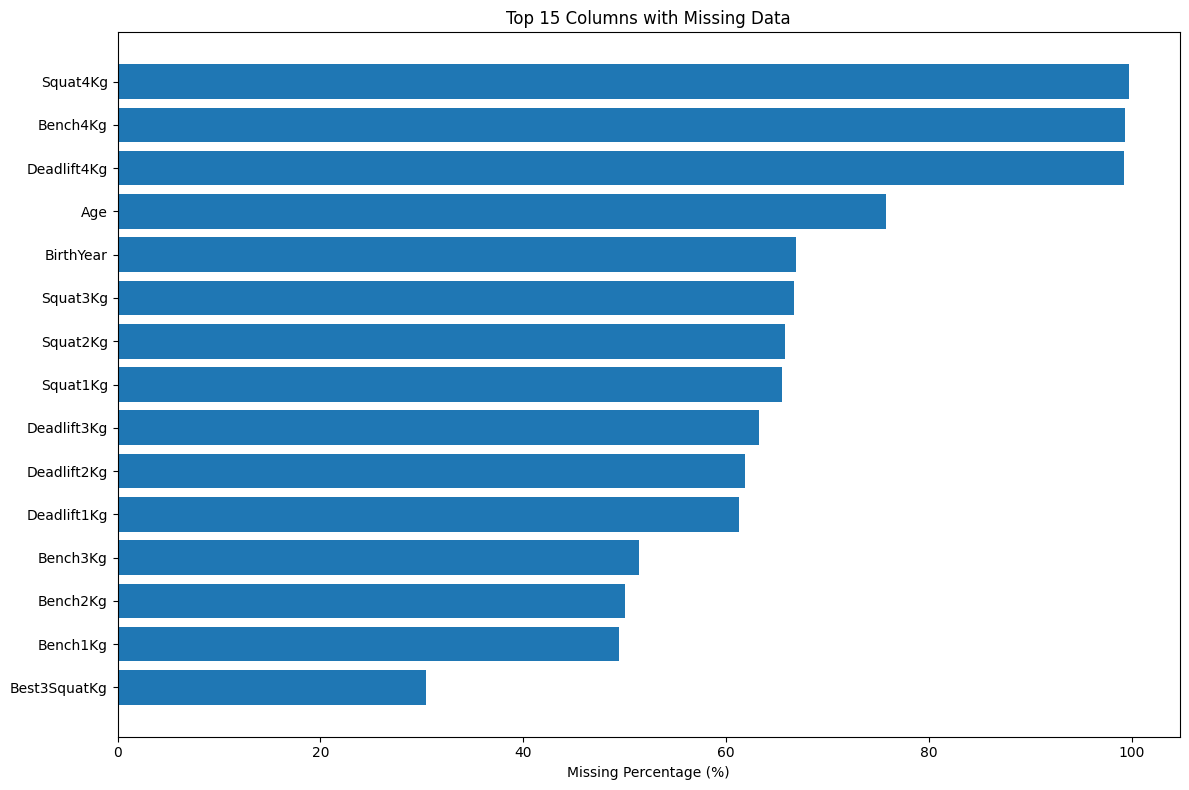

In [9]:
# Missing data analysis
missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percent': (df.isnull().sum().values / len(df) * 100)
})
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percent', ascending=False)

print("=== Missing Data Analysis ===")
print(missing_data.head(20))

# Visualize missing data
if len(missing_data) > 0:
    plt.figure(figsize=(12, 8))
    top_missing = missing_data.head(15)
    plt.barh(range(len(top_missing)), top_missing['Missing_Percent'])
    plt.yticks(range(len(top_missing)), top_missing['Column'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Top 15 Columns with Missing Data')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('../data/processed/missing_data.png', dpi=150, bbox_inches='tight')
    plt.show()


## 4. Existing Scoring Systems Comparison


In [10]:
# Compare scoring systems - SEPARATED BY (Gender × IPF Weight Class)
scoring_cols = ['Wilks', 'Dots', 'Goodlift']
available_scores = [col for col in scoring_cols if col in df_analysis.columns]

if len(available_scores) > 1 and 'IPF_WeightClass' in df_analysis.columns and 'Sex' in df_analysis.columns:
    valid_df = df_analysis[
        (df_analysis['IPF_WeightClass'].notna()) &
        (df_analysis['Sex'].isin(['M', 'F'])) &
        (df_analysis[available_scores].notna().any(axis=1))
    ].copy()
    
    if len(valid_df) > 0:
        print("=== Scoring Systems Comparison - Separated by (Gender × IPF Weight Class) ===")
        print(f"Valid entries: {len(valid_df):,}\n")
        
        men_classes = ['59kg', '66kg', '74kg', '83kg', '93kg', '105kg', '120kg', '120+kg']
        women_classes = ['47kg', '52kg', '57kg', '63kg', '69kg', '76kg', '84kg', '84+kg']
        
        print("Scoring System Correlations by (Gender × IPF Weight Class):")
        print("="*80)
        
        for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
            print(f"\n{label}:")
            print("-" * 80)
            
            for wc in classes:
                group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                
                if len(group_df) >= 50:
                    score_data = group_df[available_scores].dropna()
                    
                    if len(score_data) >= 30:
                        corr_matrix = score_data.corr()
                        print(f"\n  {label} - {wc} (n={len(score_data):,}):")
                        print(corr_matrix.round(3).to_string())
        
        # Visualizations
        print("\n\nGenerating visualizations...")
        
        major_groups = []
        for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
            for wc in classes:
                group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                score_data = group_df[available_scores].dropna()
                
                if len(score_data) >= 100:
                    major_groups.append((sex, wc, label, score_data))
        
        if len(major_groups) > 0:
            n_plots = min(6, len(major_groups))
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            axes = axes.flatten()
            
            for idx in range(n_plots):
                sex, wc, label, score_data = major_groups[idx]
                ax = axes[idx]
                
                corr_matrix = score_data.corr()
                sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                           square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
                ax.set_title(f'{label} - {wc}\n(n={len(score_data):,})', fontsize=10)
            
            for idx in range(n_plots, len(axes)):
                axes[idx].set_visible(False)
            
            plt.tight_layout()
            plt.savefig('../data/processed/scoring_correlation_by_group.png', dpi=150, bbox_inches='tight')
            plt.show()
        
        # Distribution comparison by group
        print("\nGenerating distribution plots...")
        fig, axes = plt.subplots(2, len(available_scores), figsize=(6*len(available_scores), 10))
        if len(available_scores) == 1:
            axes = axes.reshape(-1, 1)
        
        for col_idx, col in enumerate(available_scores):
            for row_idx, (sex, classes, label) in enumerate([('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]):
                ax = axes[row_idx, col_idx]
                
                for wc in classes:
                    group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                    
                    if len(group_df) >= 100:
                        data = group_df[col].dropna()
                        if len(data) > 0:
                            ax.hist(data, bins=30, alpha=0.4, label=wc, edgecolor='black', linewidth=0.5)
                
                ax.set_title(f'{col} - {label}', fontsize=12, fontweight='bold')
                ax.set_xlabel(col, fontsize=10)
                ax.set_ylabel('Frequency', fontsize=10)
                if col_idx == len(available_scores) - 1:
                    ax.legend(title='IPF Weight Class', fontsize=8, ncol=2)
                ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('../data/processed/scoring_distributions_by_group.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("✓ Visualizations saved")
    else:
        print("⚠ No valid entries with scoring data, IPF_WeightClass, and Gender")
elif len(available_scores) <= 1:
    print("⚠ Insufficient scoring systems available for comparison")
else:
    print("⚠ Missing required columns (IPF_WeightClass or Sex) for separated analysis")


⚠ Insufficient scoring systems available for comparison


In [11]:
# Compare scoring systems
scoring_cols = ['Wilks', 'Dots', 'Goodlift']
available_scores = [col for col in scoring_cols if col in df.columns]

if len(available_scores) > 1:
    # Correlation matrix
    score_data = df[available_scores].dropna()
    corr_matrix = score_data.corr()
    
    print("=== Scoring Systems Correlation ===")
    print(corr_matrix)
    
    # Visualize correlation
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Between Scoring Systems')
    plt.tight_layout()
    plt.savefig('../data/processed/scoring_correlation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Distribution comparison
    fig, axes = plt.subplots(1, len(available_scores), figsize=(6*len(available_scores), 6))
    if len(available_scores) == 1:
        axes = [axes]
    
    for idx, col in enumerate(available_scores):
        ax = axes[idx]
        data = df[col].dropna()
        ax.hist(data, bins=50, edgecolor='black', alpha=0.7)
        ax.set_title(f'{col} Distribution')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../data/processed/scoring_distributions.png', dpi=150, bbox_inches='tight')
    plt.show()


In [12]:
# Data Quality Flags - SEPARATED BY (Gender × IPF Weight Class)
# Overall quality flags removed - all analysis must be separated to prevent data skewing

if 'IPF_WeightClass' in df_analysis.columns and 'Sex' in df_analysis.columns:
    valid_df = df_analysis[df_analysis['Sex'].isin(['M', 'F'])].copy()
    
    print("=== Data Quality Flags - Separated by (Gender × IPF Weight Class) ===")
    print(f"Valid entries: {len(valid_df):,}\n")
    
    men_classes = ['59kg', '66kg', '74kg', '83kg', '93kg', '105kg', '120kg', '120+kg']
    women_classes = ['47kg', '52kg', '57kg', '63kg', '69kg', '76kg', '84kg', '84+kg']
    
    # TotalKg ranges: <100, 100-200, 200-300, 300-400, 400-500, 500-600, 600-700, 700-800, 800-900, 900-1000, 1000+kg
    total_ranges = [(0, 100), (100, 200), (200, 300), (300, 400), (400, 500), (500, 600), 
                   (600, 700), (700, 800), (800, 900), (900, 1000), (1000, 10000)]
    total_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '500-600', 
                   '600-700', '700-800', '800-900', '900-1000', '1000+']
    
    # Age ranges: <14, 14-17, 18-22, 23-29, 30-39, 40-49, 50-59, 60-69, 70+
    age_ranges = [(0, 14), (14, 18), (18, 23), (23, 30), (30, 40), (40, 50), (50, 60), (60, 70), (70, 150)]
    age_labels = ['<14', '14-17', '18-22', '23-29', '30-39', '40-49', '50-59', '60-69', '70+']
    
    print("TotalKg Ranges by (Gender × IPF Weight Class):")
    print("="*80)
    
    for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
        print(f"\n{label}:")
        print("-" * 80)
        
        for wc in classes:
            group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc) & 
                               (valid_df['TotalKg'].notna())]
            
            if len(group_df) >= 10:
                print(f"\n  {label} - {wc} (n={len(group_df):,}):")
                print(f"  {'TotalKg Range':<15} {'Count':<10} {'Percent':<10}")
                print(f"  {'-'*15} {'-'*10} {'-'*10}")
                
                for (low, high), range_label in zip(total_ranges, total_labels):
                    count = len(group_df[(group_df['TotalKg'] >= low) & (group_df['TotalKg'] < high)])
                    pct = (count / len(group_df) * 100) if len(group_df) > 0 else 0
                    if count > 0:
                        print(f"  {range_label:<15} {count:<10} {pct:<10.1f}%")
    
    print("\n\nAge Ranges by (Gender × IPF Weight Class):")
    print("="*80)
    
    for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
        print(f"\n{label}:")
        print("-" * 80)
        
        for wc in classes:
            group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc) & 
                               (valid_df['Age'].notna())]
            
            if len(group_df) >= 10:
                print(f"\n  {label} - {wc} (n={len(group_df):,}):")
                print(f"  {'Age Range':<12} {'Count':<10} {'Percent':<10}")
                print(f"  {'-'*12} {'-'*10} {'-'*10}")
                
                for (low, high), range_label in zip(age_ranges, age_labels):
                    count = len(group_df[(group_df['Age'] >= low) & (group_df['Age'] < high)])
                    pct = (count / len(group_df) * 100) if len(group_df) > 0 else 0
                    if count > 0:
                        print(f"  {range_label:<12} {count:<10} {pct:<10.1f}%")
    
    # Failed meets by group
    print("\n\nFailed Meets by (Gender × IPF Weight Class):")
    print("="*80)
    
    if 'FailedMeet' in valid_df.columns:
        for sex, classes, label in [('M', men_classes, 'MALE'), ('F', women_classes, 'FEMALE')]:
            print(f"\n{label}:")
            print("-" * 80)
            print(f"{'Weight Class':<15} {'Total':<10} {'Failed':<10} {'Failed%':<10}")
            print("-" * 80)
            
            for wc in classes:
                group_df = valid_df[(valid_df['Sex'] == sex) & (valid_df['IPF_WeightClass'] == wc)]
                
                if len(group_df) >= 10:
                    failed_count = group_df['FailedMeet'].sum() if 'FailedMeet' in group_df.columns else 0
                    failed_pct = (failed_count / len(group_df) * 100) if len(group_df) > 0 else 0
                    print(f"{wc:<15} {len(group_df):<10} {failed_count:<10} {failed_pct:<10.1f}%")
    
    print("\n✓ Data quality flags analysis complete")
else:
    print("⚠ Missing required columns (IPF_WeightClass or Sex) for separated analysis")


=== Data Quality Flags - Separated by (Gender × IPF Weight Class) ===
Valid entries: 3,449,432

TotalKg Ranges by (Gender × IPF Weight Class):

MALE:
--------------------------------------------------------------------------------

  MALE - 59kg (n=272,073):
  TotalKg Range   Count      Percent   
  --------------- ---------- ----------
  <100            28247      10.4      %
  100-200         40535      14.9      %
  200-300         42231      15.5      %
  300-400         79991      29.4      %
  400-500         57480      21.1      %
  500-600         19643      7.2       %
  600-700         3481       1.3       %
  700-800         448        0.2       %
  800-900         17         0.0       %

  MALE - 66kg (n=270,227):
  TotalKg Range   Count      Percent   
  --------------- ---------- ----------
  <100            11758      4.4       %
  100-200         52021      19.3      %
  200-300         16905      6.3       %
  300-400         43733      16.2      %
  400-500         75

## 5. Data Quality Flags


In [13]:
# Identify extreme values and potential data quality issues
print("=== Data Quality Checks ===")

# Extreme totals
if 'TotalKg' in df.columns:
    extreme_high = df[df['TotalKg'] > 2000]
    extreme_low = df[df['TotalKg'] < 50]
    print(f"Extremely high totals (>2000kg): {len(extreme_high)}")
    print(f"Extremely low totals (<50kg): {len(extreme_low)}")

# Extreme bodyweights
if 'BodyweightKg' in df.columns:
    extreme_bw_high = df[df['BodyweightKg'] > 200]
    extreme_bw_low = df[df['BodyweightKg'] < 30]
    print(f"Extremely high bodyweight (>200kg): {len(extreme_bw_high)}")
    print(f"Extremely low bodyweight (<30kg): {len(extreme_bw_low)}")

# Extreme ages
if 'Age' in df.columns:
    extreme_age_high = df[df['Age'] > 100]
    extreme_age_low = df[df['Age'] < 10]
    print(f"Extremely high age (>100): {len(extreme_age_high)}")
    print(f"Extremely low age (<10): {len(extreme_age_low)}")

# Duplicate entries (same name, same meet, same total)
if 'Name' in df.columns and 'MeetPath' in df.columns and 'TotalKg' in df.columns:
    duplicates = df.duplicated(subset=['Name', 'MeetPath', 'TotalKg'], keep=False)
    print(f"Potential duplicate entries: {duplicates.sum()}")


=== Data Quality Checks ===
Extremely high totals (>2000kg): 0
Extremely low totals (<50kg): 28214
Extremely high bodyweight (>200kg): 589
Extremely low bodyweight (<30kg): 1193
Extremely high age (>100): 0
Extremely low age (<10): 1110
Potential duplicate entries: 347290
